# Figure Mrbles Beads

## Imports

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config5 as sdc
import jax.numpy as jnp
import jax
import sdc_config3 as sdc_np
# scale bar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

## Helper functions

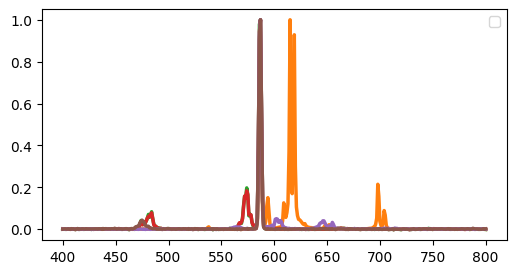

In [2]:
import numpy as np

# Draw boxes around the centroids and label bead number
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
rgb_colors = [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for color in colors]

# plot the ground truth spectra
# Specify the file path of the CSV file
file_path = "mrbles_spectra_20230412.csv"
# Read the CSV file into a NumPy array
data = np.genfromtxt(file_path, delimiter=',')
# Extract the wavelengths and spectra from the data
wavelengths_gt = data[1:, 0]
spectra_gt = data[1:, 1:]-np.expand_dims(data[1:,1], axis =1)
# Plot the ground truth spectra
plt.figure(figsize=(6, 3))
for i in range(1,spectra_gt.shape[1]):
    spectra_gt[:,i] = spectra_gt[:,i]/np.amax(spectra_gt[:,i])
    plt.plot(wavelengths_gt, spectra_gt[:,i].T, color=colors[i], linewidth=2.5)
plt.legend('')

In [45]:
# find beads in image

import cv2

def findbeadsinimage(false_color, beadsize=15, skip = [-1]):
    # Create a numpy array
    image_array = (false_color*255).astype('uint8')
    image_array_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

    # Convert the numpy array to grayscale
    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary image
    _, binary =  cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
    # plt.imshow(binary,cmap = 'gray')
    # plt.colorbar()

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to remove small noise
    min_area = beadsize  # Minimum area of a bead
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    bead_locations = []
    for cnt in filtered_contours:
        # Calculate the centroid of the contour
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        
        # Append the centroid coordinates to the bead_locations list
        bead_locations.append((cx, cy))

    # Draw boxes around the centroids and label bead number
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    rgb_colors = [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for color in colors]
    for i, (cx, cy) in enumerate(bead_locations):
        # Draw a rectangle around the centroid
        rad = 20
        x, y, w, h = cx-rad, cy-rad, 2*rad, 2*rad
        if i not in skip:
            cv2.rectangle(image_array_bgr, (x, y), (x+w, y+h), tuple(rgb_colors[i][::-1]), 2)
        
        # Label the bead number
        # cv2.putText(image_array_bgr, f"Bead {i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return (bead_locations, image_array_bgr)


def drawscalebar(ax, scalebarval, pxlsize, mag = 1, scalebarname = '1 superpixel', loc = 'upper left'):
    scalebarsize = scalebarval*mag # micron
    scalepix = int(scalebarsize/pxlsize)

    fontprops = fm.FontProperties(size=24)
    scalebar = AnchoredSizeBar(ax.transData,
                            scalepix, scalebarname, loc, 
                            pad=0.5, sep = 10,
                            color='white',
                            frameon=False,
                            size_vertical=10,
                            fontproperties=fontprops)
    return scalebar


## Plot Eu

Bead 1 - X: 479, Y: 683
Bead 2 - X: 359, Y: 486
Bead 3 - X: 95, Y: 411
Bead 4 - X: 310, Y: 222
Bead 5 - X: 391, Y: 214


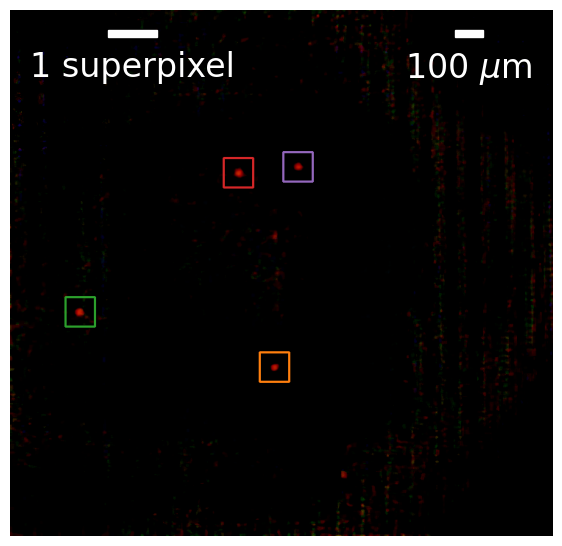

In [52]:
datafolder = '../Results/'
file = 'mrbles_code1eumeas_20db.tiff_thr=6e-06_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'
save_loc = './Figures/'
wvmin = 450
wvmax = 800
wvstep = 6
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
skip = [0]
bead_locations, image_array_bgr = findbeadsinimage(false_color, 15, skip = skip)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,160,2.4)
plt.imshow(cv2.cvtColor(image_array_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, 2.4, mag = 4*9/39, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")


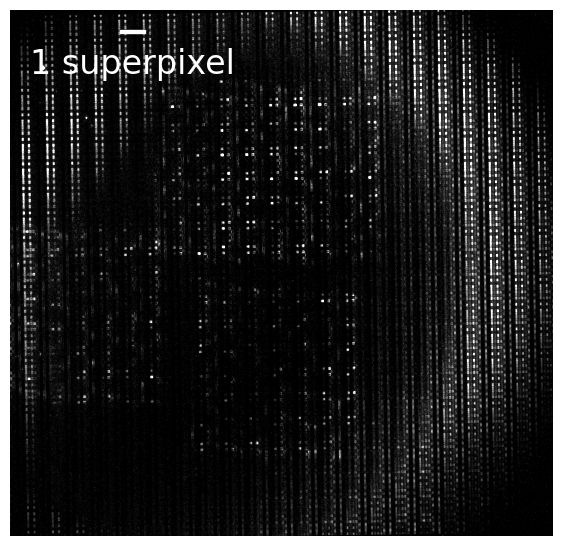

In [53]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/media/azuldata/neerja/2024-02-01/mrbles_code1eu'
meas_name = 'meas_20db.tiff'
bg_name = 'bg_20db.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.05])
plt.axis('off')

scalebar = drawscalebar(ax, 160,2.4)
ax.add_artist(scalebar)


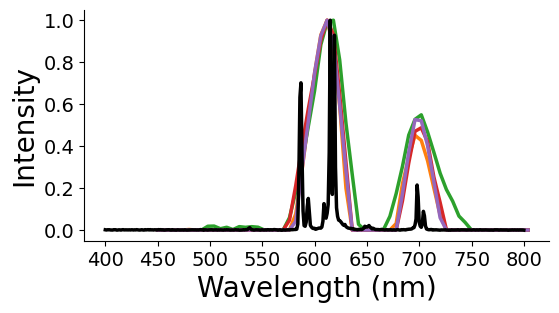

In [54]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
for i, (cx, cy) in enumerate(bead_locations):
    if i not in skip: #skip the first fake bead
        spectra[i,:] = xk[:,cy,cx]/np.max(xk[:,cy,cx])
        plt.plot(wavelengths, spectra[i, :].T, color=colors[i], linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(wavelengths_gt, spectra_gt[:,1],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

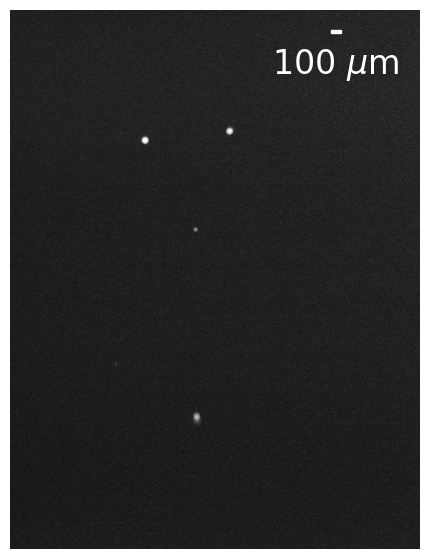

In [22]:
# draw groundtruth
#ACTION: CHANGE DATA FOLDER, SAMPLE FOLDER, BACKGROUND FOLDER TO FIND YOUR MEASUREMENT
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot,cmap='gray')
plt.axis('off')
scalebar = drawscalebar(ax, 100,3.45, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebar)

## Plot Dy

Bead 1 - X: 336, Y: 472
Bead 2 - X: 441, Y: 439
Bead 3 - X: 364, Y: 294
Bead 4 - X: 287, Y: 263
Bead 5 - X: 379, Y: 212


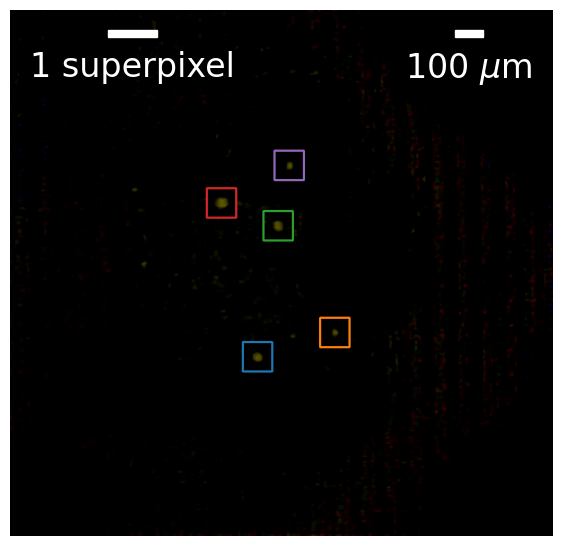

In [55]:
datafolder = '../Results/'
file = 'mrbles_code3dymeas.tiff_thr=6e-06_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)

bead_locations, image_array_bgr = findbeadsinimage(false_color, 20)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,160,2.4)
plt.imshow(cv2.cvtColor(image_array_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, 2.4, mag = 4*9/39, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")

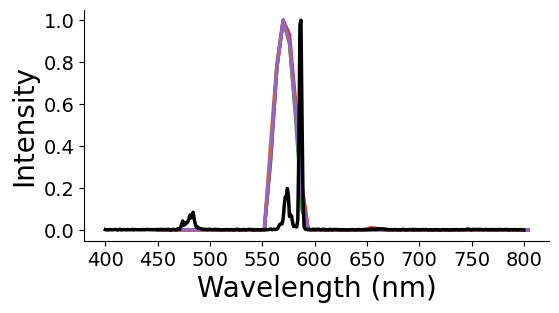

In [56]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
for i, (cx, cy) in enumerate(bead_locations):
    if i!=0: #skip the first fake bead
        spectra[i,:] = xk[:,cy,cx]/np.max(xk[:,cy,cx])
        plt.plot(wavelengths, spectra[i, :].T, color=colors[i], linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(wavelengths_gt, spectra_gt[:,2],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

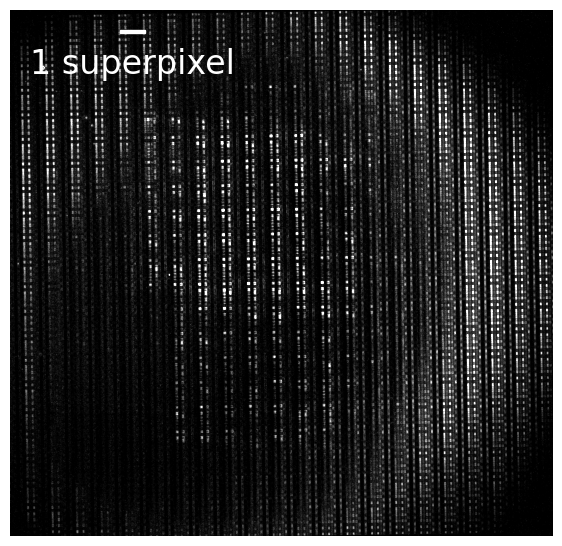

In [34]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/media/azuldata/neerja/2024-02-01/mrbles_code3dy'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.2])
plt.axis('off')

scalebar = drawscalebar(ax, 160,2.4)
ax.add_artist(scalebar)


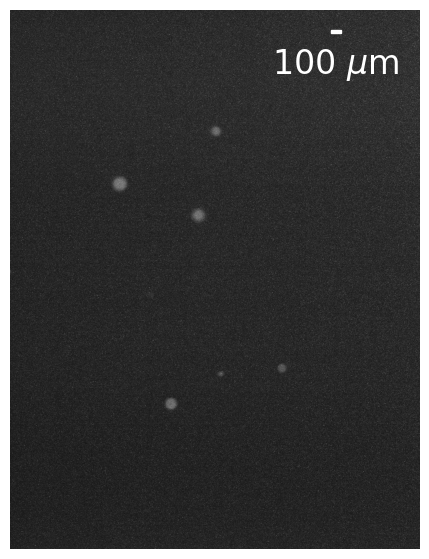

In [35]:
# draw groundtruth
#ACTION: CHANGE DATA FOLDER, SAMPLE FOLDER, BACKGROUND FOLDER TO FIND YOUR MEASUREMENT
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot,cmap='gray')
plt.axis('off')
scalebar = drawscalebar(ax, 100,3.45, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebar)